# Overall survival analysis, Figure5

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
import os,sys
from scipy import stats
from collections import Counter
plt.style.use('seaborn-white')

In [2]:
plt.rcParams['figure.figsize']=4,3
plt.rcParams['figure.dpi']=300
plt.rcParams['axes.linewidth'] =0.5
plt.rcParams['lines.linewidth'] =0.5
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

In [3]:
from lifelines import CoxPHFitter

def gt_nanmedian(array):
    m=np.nanmedian(array)
    y=[]
    for x in array:
        if x >=m:
            y.append(1)
        elif x <m:
            y.append(0)
        else:
            y.append(np.nan)
    return y

In [4]:
df=pd.read_csv('../data/ICI_OS_cohort_606.tsv',
                 sep='\t',index_col=0)
df

,Reference,Age_high,Age_category,Sex,CancerType,CancerType2,CancerType3,Treatment,Death,OS_MONTHS,irGS,TMB_high,irGS_anno,TMB_high_anno,class4,Missense_Mutation,Missense_Mutation_log10,ICI_single
Case001,"Anagnostou, NatCan 2020",0.0,50-60,Male,2_Lung,2_Lung,2_Lung,PD1,1.0,3.00,1,1.0,Yes,high,TMB-high irGS,338.0,2.530200,1
Case002,"Anagnostou, NatCan 2020",0.0,50-60,Female,2_Lung,2_Lung,2_Lung,PD1,1.0,3.00,0,0.0,No,low,TMB-low non-irGS,33.0,1.531479,1
Case003,"Anagnostou, NatCan 2020",1.0,60-70,Male,2_Lung,2_Lung,2_Lung,PD1,0.0,38.00,0,0.0,No,low,TMB-low non-irGS,2.0,0.477121,1
Case004,"Anagnostou, NatCan 2020",1.0,60-70,Male,2_Lung,2_Lung,2_Lung,PD1,1.0,2.00,1,1.0,Yes,high,TMB-high irGS,313.0,2.496930,1
Case005,"Anagnostou, NatCan 2020",0.0,50-60,Female,2_Lung,2_Lung,2_Lung,PD1,1.0,2.00,1,1.0,Yes,high,TMB-high irGS,1207.0,3.082067,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Case602,"cBioPortal, mixed_allen_2018",0.0,30-40,Female,1_Melanoma,1_Melanoma,1_Melanoma,CTLA4,1.0,5.26,1,1.0,Yes,high,TMB-high irGS,257.0,2.411620,1
Case603,"cBioPortal, mixed_allen_2018",1.0,60-70,Male,1_Melanoma,1_Melanoma,1_Melanoma,CTLA4,1.0,2.93,1,1.0,Yes,high,TMB-high irGS,826.0,2.917506,1
Case604,"cBioPortal, mixed_allen_2018",1.0,70-80,Female,1_Melanoma,1_Melanoma,1_Melanoma,CTLA4,1.0,1.22,0,1.0,No,high,TMB-high non-irGS,192.0,2.285557,1
Case605,"cBioPortal, mixed_allen_2018",1.0,80-,Male,1_Melanoma,1_Melanoma,1_Melanoma,CTLA4,1.0,8.95,1,1.0,Yes,high,TMB-high irGS,706.0,2.849419,1


In [5]:
df['Age_high'].isna().sum()

350

In [6]:
Counter(df['Treatment'])

Counter({'PD1': 131,
         'CTLA4+PD1': 6,
         'PDL1': 220,
         'PD1/PDL1': 94,
         'CTLA4': 145,
         'PD1/PDL1+CTLA4': 10})

In [7]:
df['ICI_single']=(df['Treatment'].isin(['PD1/PDL1+CTLA4','CTLA4+PD1'])==False).astype(int)

In [8]:
df.columns

Index(['Reference', 'Age_high', 'Age_category', 'Sex', 'CancerType',
       'CancerType2', 'CancerType3', 'Treatment', 'Death', 'OS_MONTHS', 'irGS',
       'TMB_high', 'irGS_anno', 'TMB_high_anno', 'class4', 'Missense_Mutation',
       'Missense_Mutation_log10', 'ICI_single'],
      dtype='object')

# Cox proportional hazard model

In [9]:
from lifelines import CoxPHFitter
duration="OS_MONTHS"
event="Death"
covs1=['irGS','TMB_high','Missense_Mutation_log10',"CancerType2",'ICI_single',"Sex","Age_high",]

# univariate analysis, categorical
results=pd.DataFrame()
for cov in covs1:
    cph=CoxPHFitter()
    tmp_df=df.copy()
    tmp_df=tmp_df[[duration,event,cov]].dropna()
    print(cov,Counter(tmp_df[cov]))
    tmp_df2=pd.get_dummies( tmp_df,drop_first=True )
    res=cph.fit( tmp_df2, duration_col=duration, event_col=event,step_size=0.1)
    add=res.summary.reindex(["exp(coef)","exp(coef) lower 95%","exp(coef) upper 95%","p"],axis=1)
    results=pd.concat([results,add],sort=False)

results_simple=np.round( results.rename(columns={ "exp(coef)":"HR","exp(coef) lower 95%":"CI low",
                                       "exp(coef) upper 95%":"CI high","p":"P-value" }),3)
p_detail=results["p"]
results_simple

irGS Counter({1: 454, 0: 152})
TMB_high Counter({0.0: 317, 1.0: 289})
Missense_Mutation_log10 Counter({1.568201724066995: 7, 1.6812412373755872: 6, 1.880813592280792: 5, 1.9912260756924949: 5, 1.9138138523837167: 5, 1.505149978319906: 5, 1.5440680443502757: 5, 2.2430380486862944: 5, 2.0170333392987803: 5, 2.164352855784437: 4, 1.8512583487190752: 4, 2.1522883443830563: 4, 2.419955748489758: 4, 2.2121876044039577: 4, 1.7634279935629371: 4, 1.6901960800285136: 4, 1.5185139398778875: 4, 2.004321373782642: 4, 2.2833012287035497: 4, 2.459392487759231: 4, 2.0211892990699383: 4, 1.845098040014257: 4, 1.6720978579357175: 4, 1.8260748027008264: 4, 1.6334684555795864: 4, 2.392696953259666: 4, 2.0644579892269186: 3, 1.7160033436347992: 3, 1.7781512503836436: 3, 1.3222192947339193: 3, 2.225309281725863: 3, 2.315970345456918: 3, 1.4313637641589874: 3, 2.385606273598312: 3, 2.502427119984433: 3, 1.8864907251724816: 3, 1.968482948553935: 3, 2.257678574869185: 3, 2.037426497940624: 3, 1.8750612633917:

,HR,CI low,CI high,P-value
covariate,,,,
irGS,0.505,0.400,0.639,0.000
TMB_high,0.501,0.399,0.630,0.000
Missense_Mutation_log10,0.508,0.409,0.631,0.000
CancerType2_2_Lung,1.061,0.750,1.501,0.737
CancerType2_3_Bladder,1.606,1.252,2.060,0.000
CancerType2_5_Others,1.382,0.607,3.143,0.441
ICI_single,0.903,0.447,1.823,0.776
Sex_Male,1.085,0.858,1.372,0.497
Age_high,1.285,0.926,1.782,0.133


In [10]:
# for table
results_simple2=np.round(results_simple,2)
results_simple2['95%CI']=["({:.2f} - {:.2f})".format(x,y) for x,y in zip(results_simple2['CI low'],results_simple2['CI high']) ]
results_simple2['p_detail']=['{:.2e}'.format(x) for x in p_detail]
results_simple2=results_simple2.reindex(['HR', '95%CI', 'P-value', 'p_detail'],axis=1)
print('Please check np.round decimal !')
results_simple2

Please check np.round decimal !


,HR,95%CI,P-value,p_detail
covariate,,,,
irGS,0.50,(0.40 - 0.64),0.00,1.10e-08
TMB_high,0.50,(0.40 - 0.63),0.00,2.92e-09
Missense_Mutation_log10,0.51,(0.41 - 0.63),0.00,1.01e-09
CancerType2_2_Lung,1.06,(0.75 - 1.50),0.74,7.37e-01
CancerType2_3_Bladder,1.61,(1.25 - 2.06),0.00,1.92e-04
CancerType2_5_Others,1.38,(0.61 - 3.14),0.44,4.41e-01
ICI_single,0.90,(0.45 - 1.82),0.78,7.76e-01
Sex_Male,1.08,(0.86 - 1.37),0.50,4.97e-01
Age_high,1.28,(0.93 - 1.78),0.13,1.33e-01


In [11]:
covs=[#'Age_high',
    #'Sex', 
    'CancerType2',
    'irGS', 'TMB_high']

In [12]:
# multivariate analysis
cph=CoxPHFitter()
tmp_df=df.copy()
tmp_df=tmp_df[[duration,event]+covs].dropna()
tmp_df2=pd.get_dummies(tmp_df,drop_first=True)
res=cph.fit( tmp_df2, duration_col=duration, event_col=event,step_size=0.1)
results=res.summary.reindex(["exp(coef)","exp(coef) lower 95%","exp(coef) upper 95%","p"],axis=1)
results_simple=np.round( results.rename(columns={ "exp(coef)":"HR","exp(coef) lower 95%":"CI low",
                                       "exp(coef) upper 95%":"CI high","p":"P-value" }),3)
p_detail=results["p"]
results_simple

,HR,CI low,CI high,P-value
covariate,,,,
irGS,0.596,0.456,0.780,0.000
TMB_high,0.638,0.491,0.828,0.001
CancerType2_2_Lung,0.900,0.635,1.277,0.556
CancerType2_3_Bladder,1.515,1.176,1.953,0.001
CancerType2_5_Others,0.909,0.396,2.087,0.822


In [13]:
# for table
results_simple2=np.round(results_simple,2)
results_simple2['95%CI']=["({:.2f} - {:.2f})".format(x,y) for x,y in zip(results_simple2['CI low'],results_simple2['CI high']) ]
results_simple2['p_detail']=['{:.2e}'.format(x) for x in p_detail]
results_simple2=results_simple2.reindex(['HR', '95%CI', 'P-value', 'p_detail'],axis=1)
print('Please check np.round decimal !')
results_simple2

Please check np.round decimal !


,HR,95%CI,P-value,p_detail
covariate,,,,
irGS,0.60,(0.46 - 0.78),0.00,1.62e-04
TMB_high,0.64,(0.49 - 0.83),0.00,7.15e-04
CancerType2_2_Lung,0.90,(0.64 - 1.28),0.56,5.56e-01
CancerType2_3_Bladder,1.52,(1.18 - 1.95),0.00,1.34e-03
CancerType2_5_Others,0.91,(0.40 - 2.09),0.82,8.22e-01


In [14]:
covs=[#"Age_high","Sex",
      "CancerType2",'irGS','Missense_Mutation_log10']
# multivariate analysis
cph=CoxPHFitter()
tmp_df=df.copy()
tmp_df=tmp_df[[duration,event]+covs].dropna()
tmp_df2=pd.get_dummies(tmp_df,drop_first=True)
res=cph.fit( tmp_df2, duration_col=duration, event_col=event,step_size=0.1)
results=res.summary.reindex(["exp(coef)","exp(coef) lower 95%","exp(coef) upper 95%","p"],axis=1)
results_simple=np.round( results.rename(columns={ "exp(coef)":"HR","exp(coef) lower 95%":"CI low",
                                       "exp(coef) upper 95%":"CI high","p":"P-value" }),3)
p_detail=results["p"]
results_simple

,HR,CI low,CI high,P-value
covariate,,,,
irGS,0.616,0.455,0.835,0.002
Missense_Mutation_log10,0.668,0.503,0.886,0.005
CancerType2_2_Lung,0.889,0.626,1.262,0.510
CancerType2_3_Bladder,1.527,1.186,1.967,0.001
CancerType2_5_Others,0.907,0.396,2.081,0.818


In [15]:
# for table
results_simple2=np.round(results_simple,2)
results_simple2['95%CI']=["({:.2f} - {:.2f})".format(x,y) for x,y in zip(results_simple2['CI low'],results_simple2['CI high']) ]
results_simple2['p_detail']=['{:.2e}'.format(x) for x in p_detail]
results_simple2=results_simple2.reindex(['HR', '95%CI', 'P-value', 'p_detail'],axis=1)
print('Please carefully check np.round decimal !')
results_simple2

Please carefully check np.round decimal !


,HR,95%CI,P-value,p_detail
covariate,,,,
irGS,0.62,(0.46 - 0.84),0.00,1.80e-03
Missense_Mutation_log10,0.67,(0.50 - 0.89),0.00,5.18e-03
CancerType2_2_Lung,0.89,(0.63 - 1.26),0.51,5.10e-01
CancerType2_3_Bladder,1.53,(1.19 - 1.97),0.00,1.04e-03
CancerType2_5_Others,0.91,(0.40 - 2.08),0.82,8.18e-01


# Kaplan Meier

In [16]:
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test,multivariate_logrank_test,pairwise_logrank_test

# make function
def KMcurve(data, duration="OS",duration_limit=None,event="Death",category=None,
                continuous=False, pcts=None,ax=None,colors=None,group_order=None,
                linewidth=None,linestyle=None,weightings=None):
    """ if you set continuous category, set pct list of percentiles from  0 to 100 """
    """ weightings, options:'wilcoxon', 'tarone-ware' ,'peto' """
    # conditional branching by category's value types
    data=data.copy()
    if duration_limit:
        data[duration]=data[duration].clip(0,duration_limit)
    if ax==None:
        ax=fig.add_subplot(111)
    if category:
        # Curate the data, by drop the raw containing "NA"
        data=data.dropna(subset=[duration,event,category]) 
        if continuous:
            if len(pcts)==0:
                print("pct were set as 50!")
                pcts=[50]
            bins=[ np.min(data[category]) ]
            labels=[category+'_0']
            for i,pct in enumerate(pcts):
                bins.append( np.percentile( data[category], pct ) )
                labels.append(category+'_'+str(i+1))
            bins.append( np.max(data[category]) )
            data[category]=pd.cut(data[category],bins=bins,labels=labels
                                 ,duplicates='drop',right=False)
            # divide samples by categories
            numbers, groups = pd.factorize(data[category])   
        else:
            numbers, groups = pd.factorize(data[category])
        
        # plot each group in one figure 
        print(numbers[:10],list(groups))
        if group_order:
            groups=group_order
        for i, group in enumerate(groups):
            tmp_df=data[ data[category]== group]
            group_size=len(tmp_df)
            kmf = KaplanMeierFitter()
            kmf.fit(durations=tmp_df[duration], event_observed=tmp_df[event],
                        label="{} ($n$={})".format(group, group_size))
            # plot
            options={}
            if colors:
                options["color"]=colors[i]
            if linewidth:
                if type(linewidth)==list:
                    options["lw"]=linewidth[i]
                else:
                    options["lw"]=linewidth
            if linestyle:
                if type(linestyle)==list:
                    options["ls"]=linestyle[i]
                else:
                    options["ls"]=linestyle
            kmf.plot(ax=ax,ci_show=False, **options,
                     show_censors=True,censor_styles={'ms': 1})
        
        print("KM plot stratified by "+ category)
        # log-rank test    
        if len(groups)==2:
            durations_A=data[ data[category]== groups[0] ][duration]
            durations_B=data[ data[category]== groups[1] ][duration]
            event_observed_A=data[ data[category]== groups[0] ][event]
            event_observed_B=data[ data[category]== groups[1] ][event]
            res=logrank_test(durations_A, durations_B, event_observed_A, event_observed_B,weightings=weightings)
            print(category,"simple log rank p=", res.summary.iloc[0,1])   
        elif  len(groups)>2:
            res= multivariate_logrank_test(event_durations=data[duration], event_observed=data[event],
                                       groups=data[category],weightings=weightings)
            print(category,"multivariate log rank p=", res.summary.iloc[0,1])
        
    else:
        print("no category ?")
        data=data.dropna(subset=[duration,event]) 
        kmf = KaplanMeierFitter()
        kmf.fit(durations=data[duration],event_observed=data[event] )
        kmf.plot(ax=ax)
        ax.set_title("KM plot none stratified" )
    
    ax.legend(title="",frameon=False,fontsize=8,edgecolor="k")
    ax.set_xlabel(duration)
    ax.set_ylabel("survival ratio")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

## All

[0 1 1 0 0 0 0 0 0 0] [1, 0]
KM plot stratified by irGS
irGS simple log rank p= 5.8251653896325085e-09


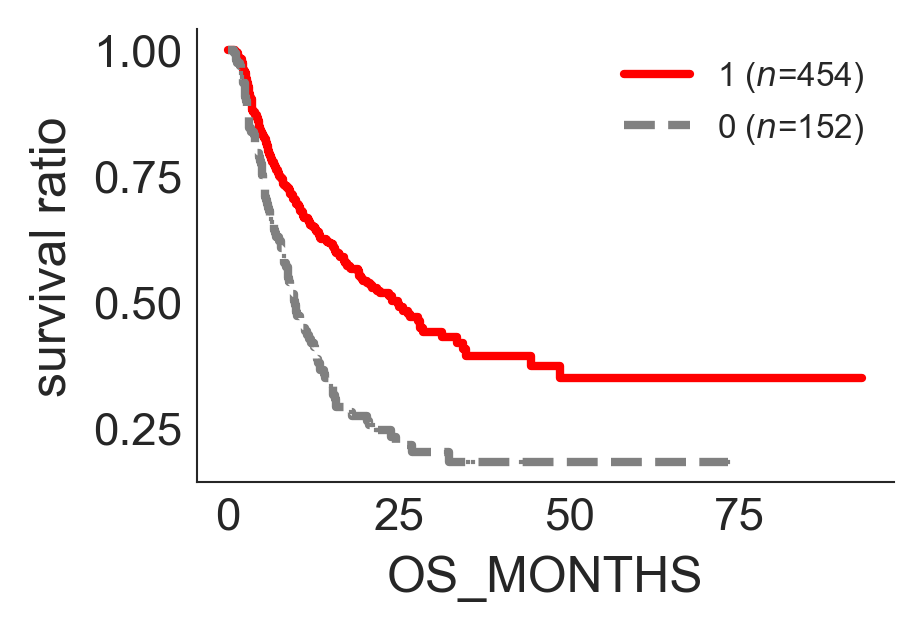

In [17]:
duration='OS_MONTHS'
event='Death'
data=df.copy()

fig=plt.figure(figsize=(3,2))
ax=fig.add_subplot(111)
KMcurve(data=df,category='irGS',duration=duration,event=event,continuous=False,
        ax=ax,group_order=[1,0],colors=['red','grey'],linewidth=2,linestyle=['-','--'])


In [18]:
duration='OS_MONTHS'
event='Death'
df['irGS_anno']=df['irGS'].replace({1:'Yes',0:'No'})
df['TMB_high_anno']=df['TMB_high'].replace({1:'high',0:'low'})

[0 1 1 0 0 0 0 0 0 0] ['Yes', 'No']
KM plot stratified by irGS_anno
irGS_anno simple log rank p= 5.8251653896325085e-09


(0.15, 1.0)

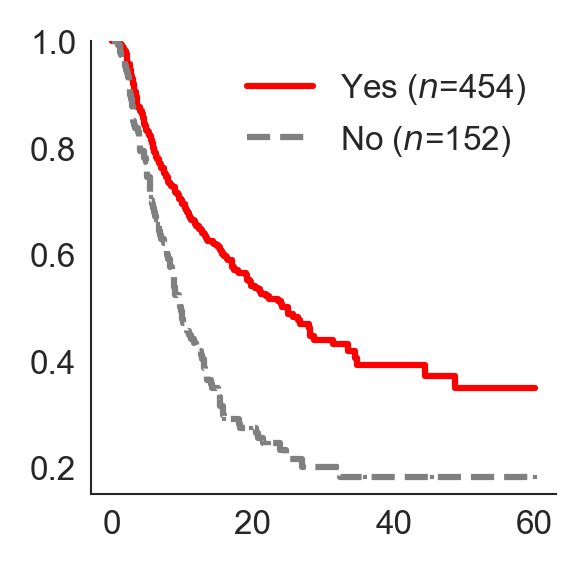

In [19]:
fig=plt.figure(figsize=(2,2))
ax=fig.add_subplot(111)
KMcurve(data=df,category='irGS_anno',duration=duration,event=event,continuous=False,
        ax=ax,group_order=['Yes','No'],colors=['red','grey'],linewidth=1.5,duration_limit=60,linestyle=['-','--'])
ax.tick_params(labelsize=8)
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim(0.15,1)

[0 1 1 0 0 0 0 1 0 1] ['high', 'low']
KM plot stratified by TMB_high_anno
TMB_high_anno simple log rank p= 1.4605178155595173e-09


(0.15, 1.0)

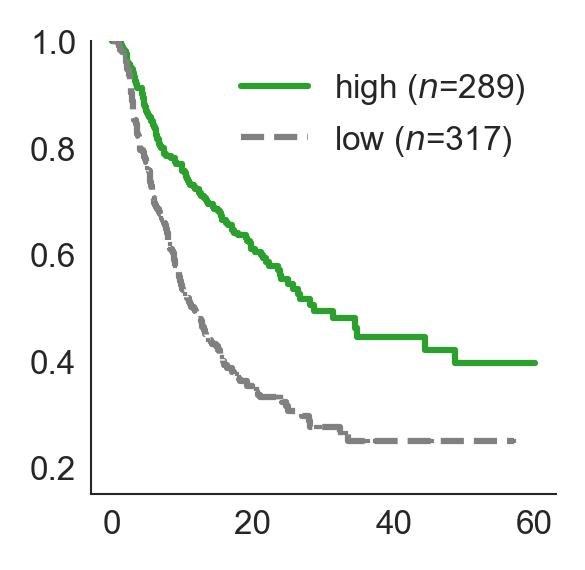

In [20]:
fig=plt.figure(figsize=(2,2))
ax=fig.add_subplot(111)
KMcurve(data=df,category='TMB_high_anno',duration=duration,event=event,continuous=False,
        ax=ax,group_order=['high','low'],colors=['tab:green','grey'],linewidth=1.5,duration_limit=60,linestyle=['-','--'])
ax.tick_params(labelsize=8)
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim(0.15,1)

In [21]:
class4=[]
for idx in df.index:
    if df.loc[idx,'irGS']==1:
        if df.loc[idx,'TMB_high']==1:
            class4.append('TMB-high irGS')
        elif df.loc[idx,'TMB_high']==0:
            class4.append('TMB-low irGS')
        else:
            print(idx)
    elif df.loc[idx,'irGS']==0:
        if df.loc[idx,'TMB_high']==1:
            class4.append('TMB-high non-irGS')
        elif df.loc[idx,'TMB_high']==0:
            class4.append('TMB-low non-irGS')
        else:
            print(idx)
    else:
        print(idx)
df['class4']=class4

In [22]:
df['class4'].unique()

array(['TMB-high irGS', 'TMB-low non-irGS', 'TMB-low irGS',
       'TMB-high non-irGS'], dtype=object)

[0 1 1 0 0 0 0 2 0 2] ['TMB-high irGS', 'TMB-low non-irGS', 'TMB-low irGS', 'TMB-high non-irGS']
KM plot stratified by class4
class4 multivariate log rank p= 8.990682017163919e-11


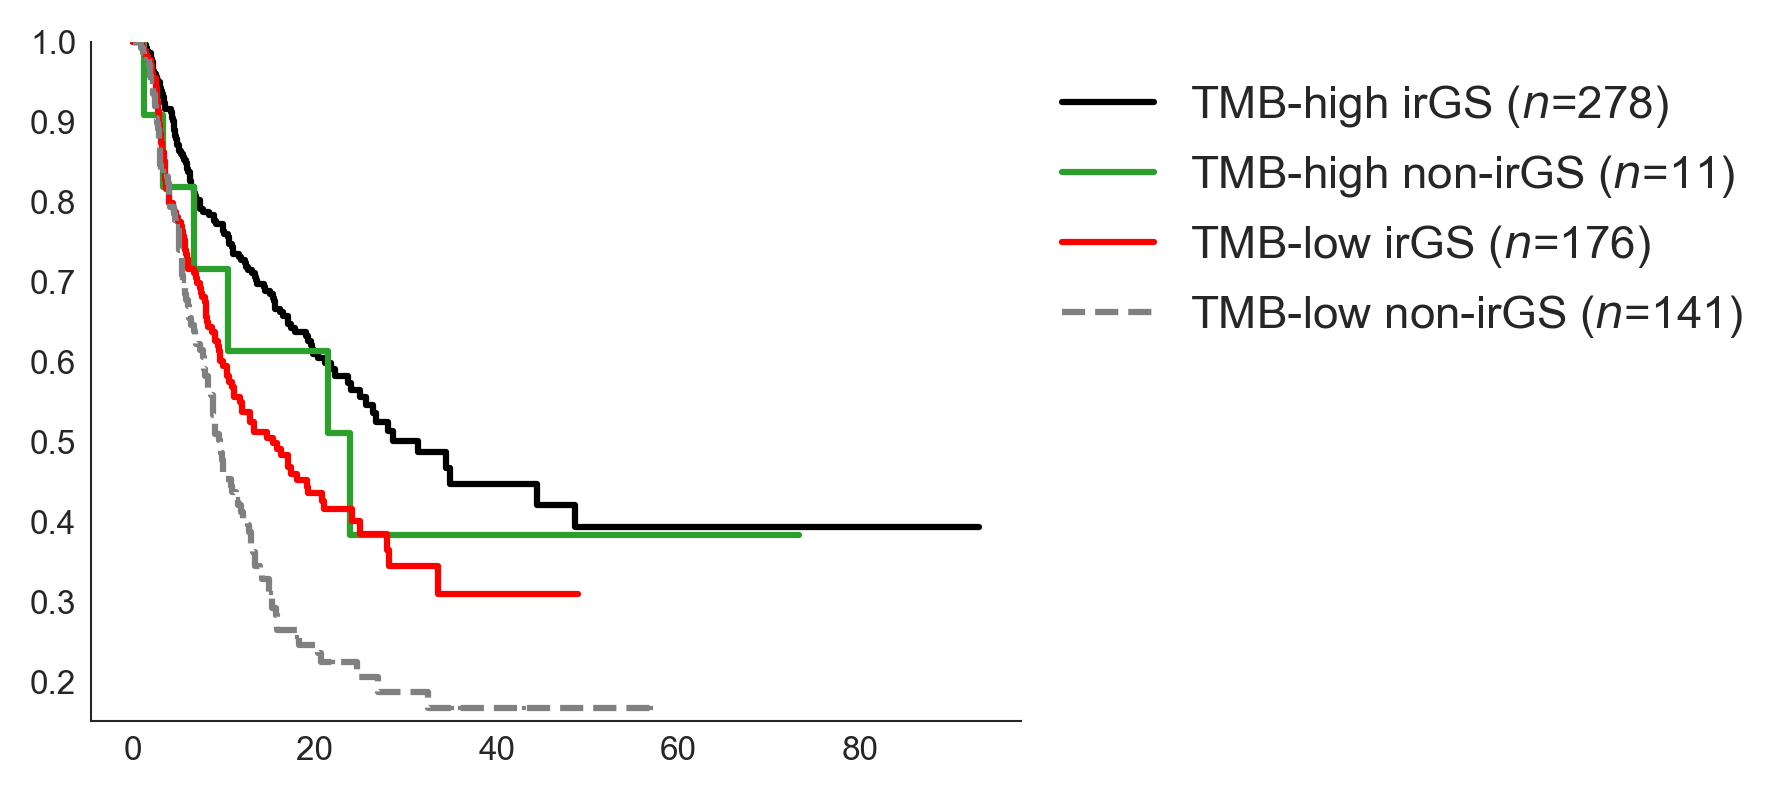

In [23]:
fig=plt.figure(figsize=(4,3))
ax=fig.add_subplot(111)
KMcurve(data=df,category='class4',duration=duration,event=event,continuous=False,
        ax=ax,linewidth=1.5,
       group_order=['TMB-high irGS','TMB-high non-irGS','TMB-low irGS', 'TMB-low non-irGS',
       ],
        colors=['black','tab:green','red','grey'],linestyle=['-']*3+['--']
       )
ax.tick_params(labelsize=8)
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim(0.15,1)
ax.legend(bbox_to_anchor=(1,1))

[0 1 1 0 0 0 0 2 0 2] ['TMB-high irGS', 'TMB-low non-irGS', 'TMB-low irGS', 'TMB-high non-irGS']
KM plot stratified by class4
class4 multivariate log rank p= 8.990682017163919e-11


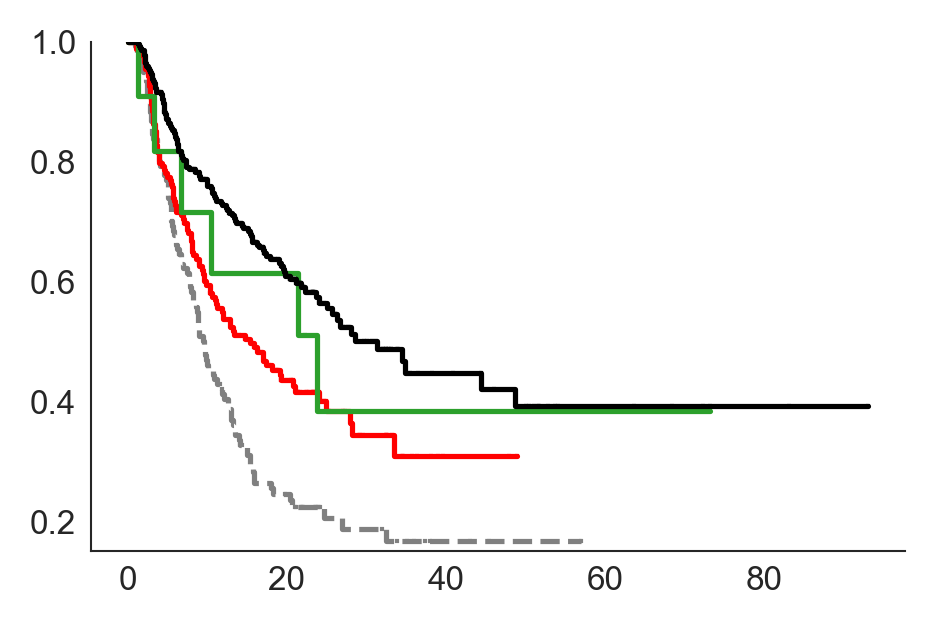

In [24]:
group_order=['TMB-high irGS','TMB-high non-irGS','TMB-low irGS', 'TMB-low non-irGS']
colors=['black','tab:green','red','grey']
fig=plt.figure(figsize=(3.5,2.25))
ax=fig.add_subplot(111)
KMcurve(data=df,category='class4',duration=duration,event=event,continuous=False,
        ax=ax,linewidth=1.25,
       group_order=group_order[::-1],
       colors=colors[::-1]
       ,linestyle=['--']*1+['-']*3)
ax.tick_params(labelsize=8)
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim(0.15,1)
ax.legend('')

## Melanoma

In [25]:
df_sel=df[df['CancerType']=='1_Melanoma']

[0 1 1 2 0 0 2 0 0 0] ['TMB-high irGS', 'TMB-low non-irGS', 'TMB-low irGS', 'TMB-high non-irGS']
KM plot stratified by class4
class4 multivariate log rank p= 0.00020705849343060606


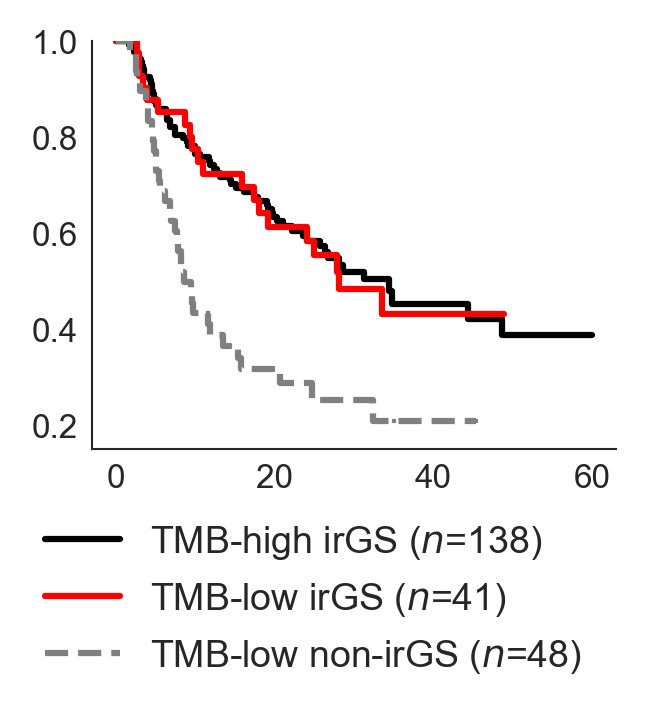

In [26]:
fig=plt.figure(figsize=(2.25,1.8))
ax=fig.add_subplot(111)
KMcurve(data=df_sel,category='class4',duration=duration,event=event,continuous=False,
        ax=ax,linewidth=1.5,duration_limit=60,
       group_order=['TMB-high irGS',#'TMB-high non-irGS',
                    'TMB-low irGS', 'TMB-low non-irGS',
       ],
        colors=['black',#'green',
                'red','grey'],linestyle=['-','-','--']
       )
ax.tick_params(labelsize=8)
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim(0.15,1)
ax.legend(bbox_to_anchor=(1,-0.1),fontsize=9)


## Lung

In [27]:
df_sel=df[df['CancerType']=='2_Lung']

[0 1 1 0 0 0 0 2 0 2] ['TMB-high irGS', 'TMB-low non-irGS', 'TMB-low irGS', 'TMB-high non-irGS']
KM plot stratified by class4
class4 multivariate log rank p= 0.01448480448503034


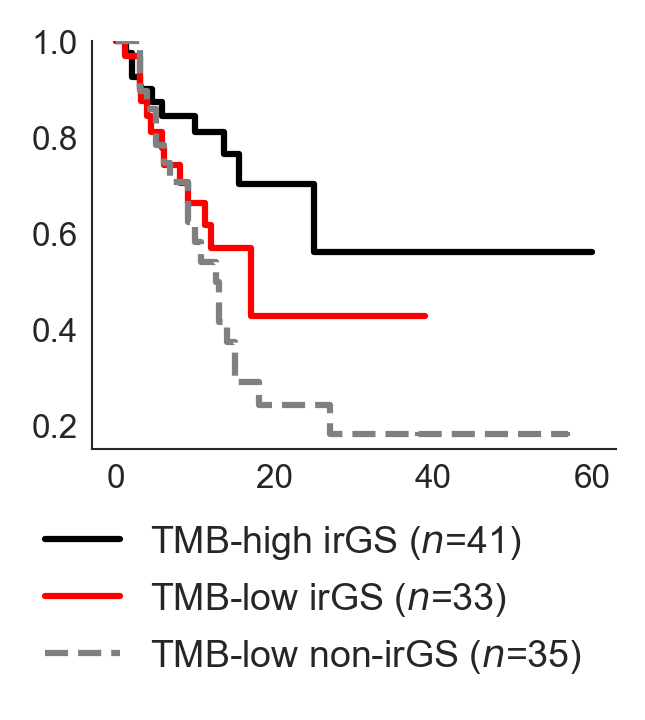

In [28]:
fig=plt.figure(figsize=(2.25,1.8))
ax=fig.add_subplot(111)
KMcurve(data=df_sel,category='class4',duration=duration,event=event,continuous=False,
        ax=ax,linewidth=1.5,duration_limit=60,
       group_order=['TMB-high irGS',#'TMB-high non-irGS',
                    'TMB-low irGS', 'TMB-low non-irGS',
       ],
        colors=['black',#'green',
                'red','grey'],linestyle=['-','-','--']
       )
ax.tick_params(labelsize=8)
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim(0.15,1)
ax.legend(bbox_to_anchor=(1,-0.1),fontsize=9)


## Bladder

In [29]:
df_sel=df[df['CancerType']=='3_Bladder']

[0 1 2 1 1 1 0 1 1 1] ['TMB-high irGS', 'TMB-low irGS', 'TMB-low non-irGS', 'TMB-high non-irGS']
KM plot stratified by class4
class4 multivariate log rank p= 7.613930287518852e-06


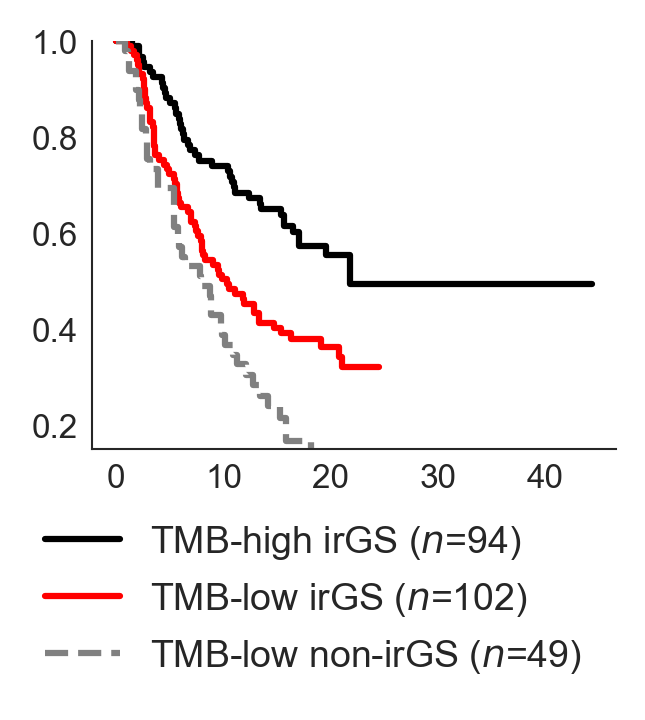

In [30]:
fig=plt.figure(figsize=(2.25,1.8))
ax=fig.add_subplot(111)
KMcurve(data=df_sel,category='class4',duration=duration,event=event,continuous=False,
        ax=ax,linewidth=1.5,duration_limit=60,
       group_order=['TMB-high irGS',#'TMB-high non-irGS',
                    'TMB-low irGS', 'TMB-low non-irGS',
       ],
        colors=['black',#'green',
                'red','grey'],linestyle=['-','-','--']
       )
ax.tick_params(labelsize=8)
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim(0.15,1)
ax.legend(bbox_to_anchor=(1,-0.1),fontsize=9)
